In [1]:
import pickle as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
import umap

In [3]:
from scipy.spatial.distance import pdist, squareform

## Letters

In [ ]:
embedding_pth = "embeddings_letters_200.pkl"
embedding = pkl.load(open(embedding_pth, "rb"))


In [5]:
embedding.keys()

dict_keys(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Z', 'X', 'Y'])

In [6]:
embedding['A'].keys()

dict_keys(['source', 'embed'])

In [7]:
len(embedding['A']['source']) # list of length 10


200

In [8]:
embedding['A']['source'][0].shape

torch.Size([1709, 2])

In [9]:
embedding['A']['embed'][0].shape

torch.Size([1, 64])

In [10]:
len(embedding['A']['embed'])

200

In [11]:
keys_list = []
values_array = []

#embeds = {}
for key in embedding.keys():
    # concat to numpy array
    keys_list += [key] * len(embedding[key]['embed'])
    values_array += [embedding[key]['embed'][i].detach().cpu().squeeze().numpy().tolist() for i in range(len(embedding[key]['embed']))]
    #embeds[key] = embedding[key]['embed'].detach().cpu().numpy()

keys_list = np.array(keys_list)
values_array = np.array(values_array)

values_array.shape

(5200, 64)

In [12]:
keys_list

array(['A', 'A', 'A', ..., 'Y', 'Y', 'Y'], dtype='<U1')

In [13]:
# UMAP

umap_model = umap.UMAP(n_components=2, random_state=0, min_dist=0.5, n_neighbors=10)
#umap_model = umap.UMAP(n_components=2, random_state=0, min_dist=0.25, n_neighbors=10)
X_umap = umap_model.fit_transform(values_array)

df = pd.DataFrame(X_umap, columns=['Dimension 1', 'Dimension 2'])
df['Label'] = keys_list


/h/lazar/.conda/envs/mfm/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


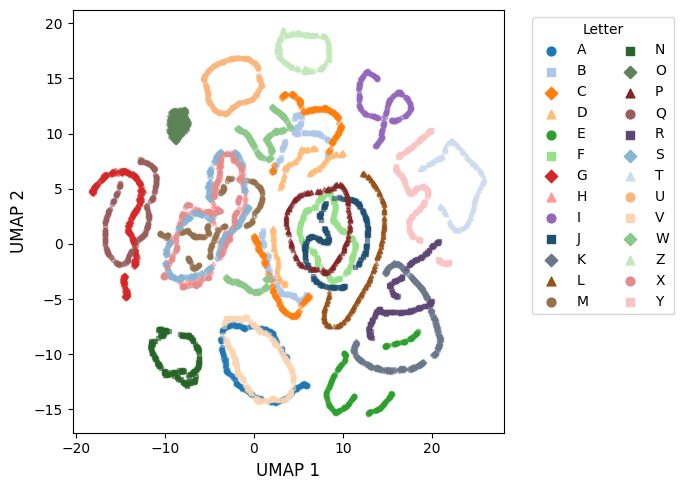

In [14]:
from matplotlib.legend_handler import HandlerTuple

# Define 9 base colors from a more prominent palette (e.g., "tab20")
base_colors = sns.color_palette("tab20", 9)

# Generate lighter and darker variants of the base colors
lighter_colors = [sns.light_palette(color, n_colors=3)[1] for color in base_colors]  # Slightly lighter shades
darker_colors = [sns.dark_palette(color, n_colors=3)[1] for color in base_colors]    # Slightly darker shades

# Combine all colors into a single palette (total 26 colors, ignoring the last one)
all_colors = base_colors + darker_colors + lighter_colors[:8]  # Use only 8 lighter shades to make 26 colors

# Get unique labels
unique_labels = df['Label'].unique()

# Create a dictionary mapping labels to colors
label_color_dict = dict(zip(unique_labels, all_colors))

# Define 4 marker styles
markers = ['o', 's', 'D', '^']  # Circle, square, diamond, and triangle
marker_styles = {}
for i, label in enumerate(unique_labels):
    marker_styles[label] = markers[i % len(markers)]  # Cycle through 4 marker styles for labels

# Add slight jitter to reduce overlap
def add_jitter(values, jitter_strength=0.02):
    return values + np.random.uniform(-jitter_strength, jitter_strength, size=len(values))

# Plotting
plt.figure(figsize=(7, 5))  # Adjusted figure size

for label in unique_labels:
    subset = df[df['Label'] == label]
    plt.scatter(
        add_jitter(subset['Dimension 1']),  # Add jitter to Dimension 1
        add_jitter(subset['Dimension 2']),  # Add jitter to Dimension 2
        label=label,
        color=label_color_dict[label],
        alpha=0.5,  # Transparency
        s=10,  # Point size
        marker=marker_styles[label],  # Use the marker style
        #edgecolors='w',  # Black edges for contrast
        #linewidth=1,  # Edge line width
    )

# Create a custom legend with controlled marker sizes
legend_handles = []
for label in unique_labels:
    legend_handles.append(plt.scatter([], [], label=label, color=label_color_dict[label], 
                                       marker=marker_styles[label], s=40, rasterized=True))  # Legend marker size

plt.xlabel("UMAP 1", fontsize=12)
plt.ylabel("UMAP 2", fontsize=12)
plt.legend(
    handles=legend_handles,
    title="Letter",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize=10,
    title_fontsize=10,
    ncol=2,  # Make legend have 2 columns
    scatterpoints=1  # Control number of marker points in legend
)
plt.tight_layout()
plt.savefig("figs/umap_letters.pdf", dpi=300)
plt.show()

In [15]:
letter_mean = df.groupby('Label').mean()
letter_mean

pairwise_distances = pdist(letter_mean, metric='euclidean')  # Change metric if needed
distance_matrix = squareform(pairwise_distances)

# Convert distance matrix to DataFrame for easier plotting
distance_df = pd.DataFrame(distance_matrix, index=letter_mean.index, columns=letter_mean.index)

/h/lazar/.conda/envs/mfm/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/h/lazar/.conda/envs/mfm/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


<Figure size 700x500 with 0 Axes>

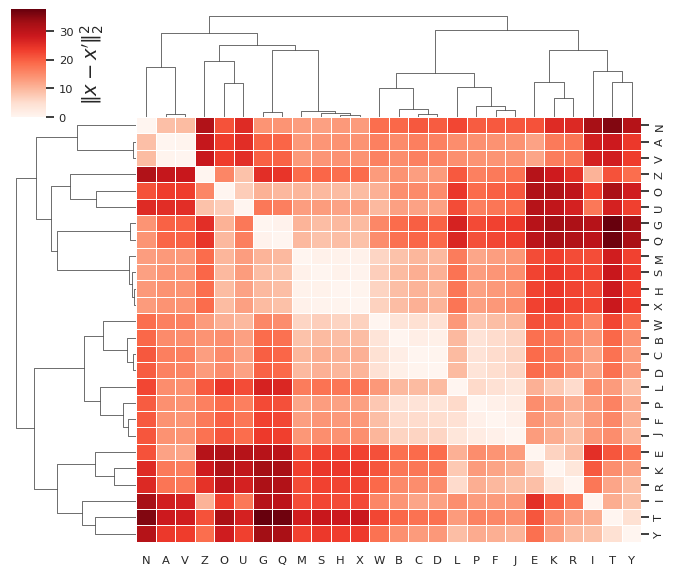

In [16]:
sns.set_theme(style="white")  # Set a clean theme
plt.figure(figsize=(7, 5))
sns.set(font_scale=0.75)
clustermap = sns.clustermap(
    distance_df,
    cmap="Reds",  # Monochrome color scheme
    method="average",  # Clustering method (e.g., average, single, complete)
    metric="euclidean",  # Distance metric for clustering
    linewidths=0.5,  # Add lines between cells for better visibility
    annot=False,  # Show numerical values in cells
    fmt=".2f",  # Format for annotations
    figsize=(7, 6)  # Adjust figure size
)

# Customize plot appearance
#plt.title("Clustered Heatmap with Monochrome Color Scheme", pad=90)
clustermap.ax_heatmap.set_xlabel("", fontsize=12)
clustermap.ax_heatmap.set_ylabel("", fontsize=12)
colorbar = clustermap.ax_heatmap.collections[0].colorbar
colorbar.set_label(r"$\Vert x - x' \Vert_2^2$", fontsize=14)  # Add colorbar label

plt.savefig("figs/heatmap_letters.pdf", dpi=300)
plt.show()

## Patients

In [ ]:
embedding_pth = "mfm_embeddings_patients_pdo27.pkl"
embedding = pkl.load(open(embedding_pth, "rb"))


In [18]:
keys_list = []
values_array = []

#embeds = {}
for key in embedding.keys():
    # concat to numpy array
    keys_list += [key] * len(embedding[key]['embed'])
    values_array += [embedding[key]['embed'][i].detach().cpu().squeeze().numpy().tolist() for i in range(len(embedding[key]['embed']))]
    #embeds[key] = embedding[key]['embed'].detach().cpu().numpy()

keys_list = np.array(keys_list)
values_array = np.array(values_array)

values_array.shape

(927, 128)

In [19]:
keys_list

array(['pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5',
       'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5',
       'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5',
       'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5',
       'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5',
       'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5',
       'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5',
       'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5',
       'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5',
       'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5',
       'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5',
       'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5',
       'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5',
       'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5', 'pdo-5',
       'pdo-11', 'pd

In [20]:
# UMAP

umap_model_pdos = umap.UMAP(n_components=2, random_state=0, min_dist=1, n_neighbors=50)
X_umap_pdos = umap_model_pdos.fit_transform(values_array)

df_pdos = pd.DataFrame(X_umap_pdos, columns=['Dimension 1', 'Dimension 2'])
df_pdos['Label'] = keys_list


/h/lazar/.conda/envs/mfm/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


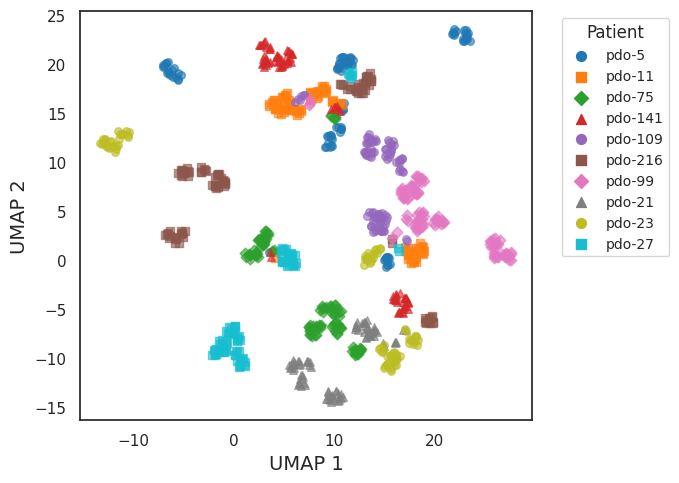

In [21]:
sns.set_theme(style="white")  # Set a clean theme

# Define 10 base colors from a prominent palette (e.g., "tab10")
base_colors = sns.color_palette("tab10", 10)  # 10 distinct colors for 10 patients

# Get unique labels (patients)
unique_labels = df_pdos['Label'].unique()

# Create a dictionary mapping labels to colors
label_color_dict = dict(zip(unique_labels, base_colors))

# Define 4 marker styles
markers = ['o', 's', 'D', '^']  # Circle, square, diamond, triangle
marker_styles = {}
for i, label in enumerate(unique_labels):
    marker_styles[label] = markers[i % len(markers)]  # Cycle through 4 marker styles

# Add slight jitter to reduce overlap
def add_jitter(values, jitter_strength=0.02):
    return values + np.random.uniform(-jitter_strength, jitter_strength, size=len(values))

# Plotting
plt.figure(figsize=(7, 5))  # Adjusted figure size

for label in unique_labels:
    subset = df_pdos[df_pdos['Label'] == label]
    plt.scatter(
        add_jitter(subset['Dimension 1']),  # Add jitter to Dimension 1
        add_jitter(subset['Dimension 2']),  # Add jitter to Dimension 2
        label=label,
        color=label_color_dict[label],
        alpha=0.6,  # Transparency
        s=30,  # Point size
        marker=marker_styles[label],  # Use the marker style
    )

# Create a custom legend with controlled marker sizes
legend_handles = [
    plt.scatter([], [], label=label, color=label_color_dict[label], 
                marker=marker_styles[label], s=50, rasterized=True)  # Legend marker size
    for label in unique_labels
]

# Add labels and legend
plt.xlabel("UMAP 1", fontsize=14)
plt.ylabel("UMAP 2", fontsize=14)
plt.legend(
    handles=legend_handles,
    title="Patient",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize=10,
    title_fontsize=12,
    ncol=1,  # Make legend have 2 columns
    scatterpoints=1  # Control number of marker points in legend
)

plt.tight_layout()
plt.savefig("figs/umap_pdos.pdf", dpi=300)
plt.show()


In [22]:
pdos_mean = df_pdos.groupby('Label').mean()
pdos_mean

pairwise_distances_pdos = pdist(pdos_mean, metric='euclidean')  # Change metric if needed
distance_pdos_matrix = squareform(pairwise_distances_pdos)

# Convert distance matrix to DataFrame for easier plotting
distance_pdos_df = pd.DataFrame(distance_pdos_matrix, index=pdos_mean.index, columns=pdos_mean.index)

/h/lazar/.conda/envs/mfm/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/h/lazar/.conda/envs/mfm/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


<Figure size 700x500 with 0 Axes>

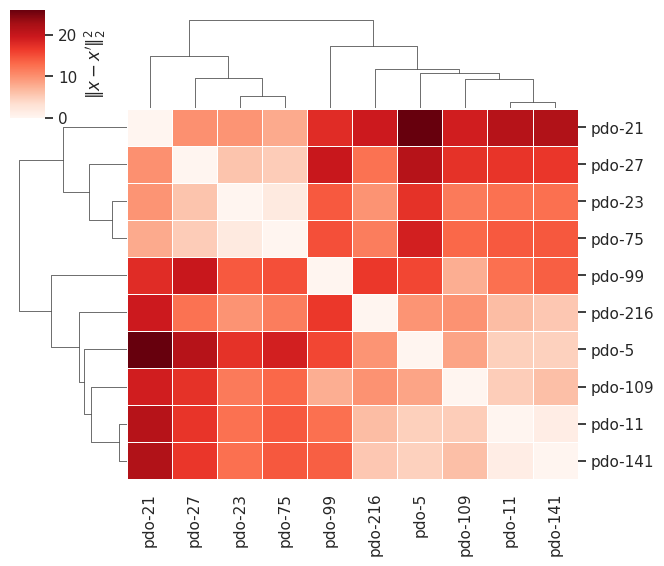

In [23]:
sns.set_theme(style="white")  # Set a clean theme
plt.figure(figsize=(7, 5))
clustermap = sns.clustermap(
    distance_pdos_df,
    cmap="Reds",  # Monochrome color scheme
    method="average",  # Clustering method (e.g., average, single, complete)
    metric="euclidean",  # Distance metric for clustering
    linewidths=0.5,  # Add lines between cells for better visibility
    annot=False,  # Show numerical values in cells
    fmt=".2f",  # Format for annotations
    figsize=(7, 6)  # Adjust figure size
)

# Customize plot appearance
#plt.title("Clustered Heatmap with Monochrome Color Scheme", pad=90)
clustermap.ax_heatmap.set_xlabel("", fontsize=12)
clustermap.ax_heatmap.set_ylabel("", fontsize=12)
colorbar = clustermap.ax_heatmap.collections[0].colorbar
colorbar.set_label(r"$\Vert x - x' \Vert_2^2$", fontsize=12)  # Add colorbar label

plt.savefig("figs/heatmap_pdos.pdf", dpi=300)
plt.show()